In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PySulfSat as ss
import Thermobar as pt
import scipy

## First, we make parameterizations of how FeO, T_K, X_Sulf etc. correlate to the amount of post-entrapment crystallization
- This is because we have to feed FeO, temperature, and liquid Ni and Cu into the Kiseeva function

In [2]:
PEC_lin=np.linspace(0, 30, 30) # Linspace for different PEC amounts

In [3]:
# Loading 2018 melt inclusion data
All2018_MI=pd.read_excel(r'../Spreadsheets/Supporting_Information_2.xlsx', sheet_name="Wieser_Ol_Hosted_MI_2018")

JustF8_MI=(All2018_MI['Sample number']=="LL4")|(All2018_MI['Sample number']=="LL7")|(All2018_MI['Sample number']=="LL8")
F8_MI=All2018_MI.loc[JustF8_MI].reset_index(drop=True)
LL4_MI=All2018_MI['Sample number']=="LL4"
LL7_MI=All2018_MI['Sample number']=="LL7"
LL8_MI=All2018_MI['Sample number']=="LL8"

# Loading 2018 matrix glass
All2018_MG=pd.read_excel(r'../Spreadsheets/Supporting_Information_2.xlsx', sheet_name="Wieser_MatrixGlass_2018")
JustF8_MG=(All2018_MG['Sample number']=="LL4")|(All2018_MG['Sample number']=="LL7")|(All2018_MG['Sample number']=="LL8")
F8_MG=All2018_MG.loc[JustF8_MG]

grad=130
inter=-330
S_Degass_Lim=grad*F8_MI['FeO_MI EPMA']+inter
Degass=F8_MI['S_MI EPMA (ppm)']<S_Degass_Lim
Undegass=(F8_MI['S_MI EPMA (ppm)']>=S_Degass_Lim)
Degassed_Wieser=F8_MI.loc[F8_MI['S_MI EPMA (ppm)']<S_Degass_Lim]
Undegassed_Wieser=F8_MI.loc[(F8_MI['S_MI EPMA (ppm)']>=S_Degass_Lim)]

Has_Sulf_Wieser=F8_MI['S_Sulf']>0


## Regression for FeO as a function of PEC
- We need this to feed into the Kiseeva model for Kd of Cu

[-0.17326694]
[11.41404734]


Text(0, 0.5, 'FeOt')

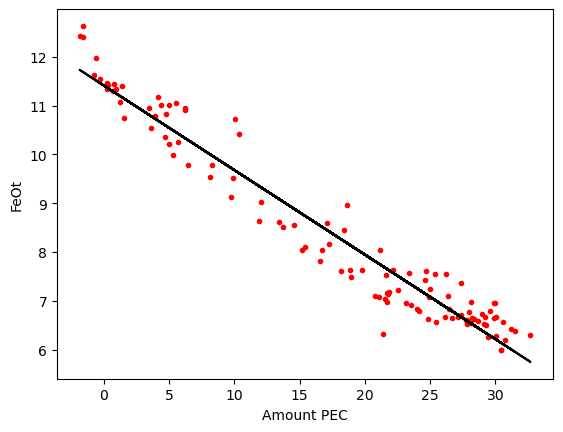

In [4]:
Reg_PEC_FeO=pt.calculate_R2(F8_MI['Amount  PEC (%)'], F8_MI['FeO_MI EPMA'])
plt.plot(F8_MI['Amount  PEC (%)'], F8_MI['FeO_MI EPMA'], '.r')
plt.plot(Reg_PEC_FeO['x_pred'], Reg_PEC_FeO['y_pred'], '-k')
print(Reg_PEC_FeO['Grad'])
print(Reg_PEC_FeO['Int'])
plt.xlabel('Amount PEC')
plt.ylabel('FeOt')

## Regression for MgO

In [5]:
# Reg_PEC_MgO=pt.calculate_R2(F8_MI['Amount  PEC (%)'], F8_MI['MgO_MI EPMA'])
# plt.plot(F8_MI['Amount  PEC (%)'], F8_MI['MgO_MI EPMA'], '.r')
# plt.plot(Reg_PEC_MgO['x_pred'], Reg_PEC_MgO['y_pred'], '-k')
# print(Reg_PEC_MgO['Grad'])
# print(Reg_PEC_MgO['Int'])
# plt.xlabel('Amount PEC')
# plt.ylabel('MgO')

## ... For Ni
- We need this for our Kiseeva calculation of KD. 

[1.42193223]
[76.8310635]


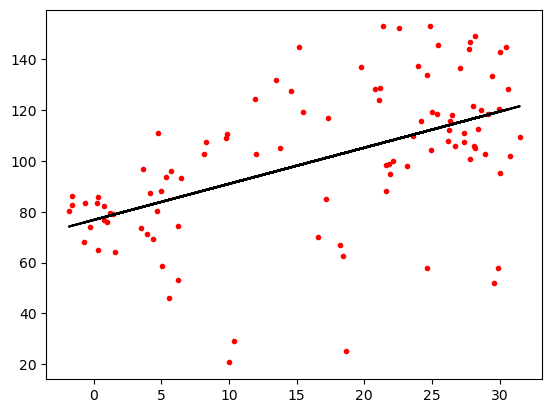

In [6]:
Reg_PEC_Ni=pt.calculate_R2(F8_MI['Amount  PEC (%)'], F8_MI['Ni_ppm_m60 LAICPMS'])
plt.plot(F8_MI['Amount  PEC (%)'], F8_MI['Ni_ppm_m60 LAICPMS'], '.r')
plt.plot(Reg_PEC_Ni['x_pred'], Reg_PEC_Ni['y_pred'], '-k')
print(Reg_PEC_Ni['Grad'])
print(Reg_PEC_Ni['Int'])

## Choosing a starting Cu value
- This is what we are trying to model - so lets pick a reasonable starting point, using inclusions which have experienced no PEC 
- You can see 170 ppm seems a reasonable choice (black star)

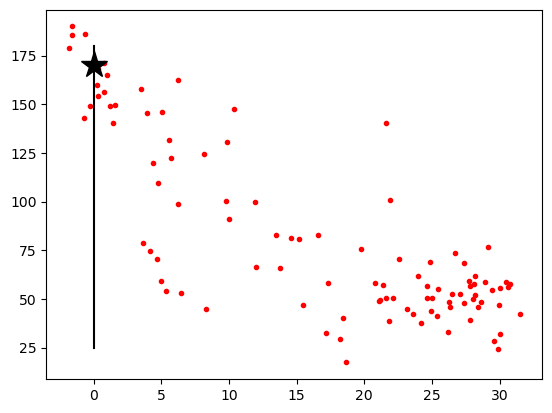

In [7]:
plt.plot(F8_MI['Amount  PEC (%)'], F8_MI['Cu_ppm_m65 LAICPMS'], '.r')
plt.plot([0, 0], [25, 180], '-k')
plt.plot(0, 170, '*k', ms=20)

## Regression for temperature
- We want the temperature at the final step of re-equilibratoin (at least for the non -re-equilibraton model)

In [12]:
F8_MI['T_K']=21.2*F8_MI['MgO_MI EPMA']+1017+273.15

[0.23982905]
[1413.08193293]


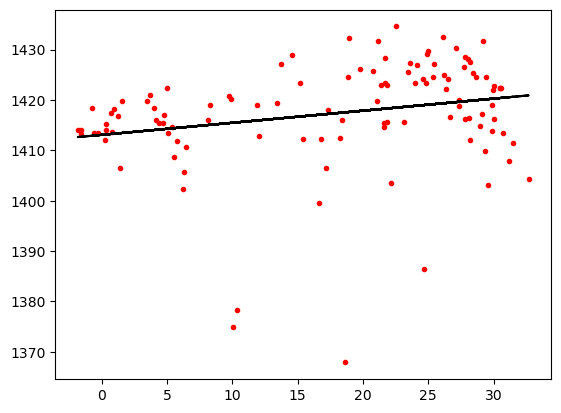

In [13]:
Reg_PEC_T_K=pt.calculate_R2(F8_MI['Amount  PEC (%)'], F8_MI['T_K'])
plt.plot(F8_MI['Amount  PEC (%)'], F8_MI['T_K'], '.r')
plt.plot(Reg_PEC_T_K['x_pred'], Reg_PEC_T_K['y_pred'], '-k')
print(Reg_PEC_T_K['Grad'])
print(Reg_PEC_T_K['Int'])

## Regression for S lost as a function of PEC

[-17.97011561]
[1270.44947171]


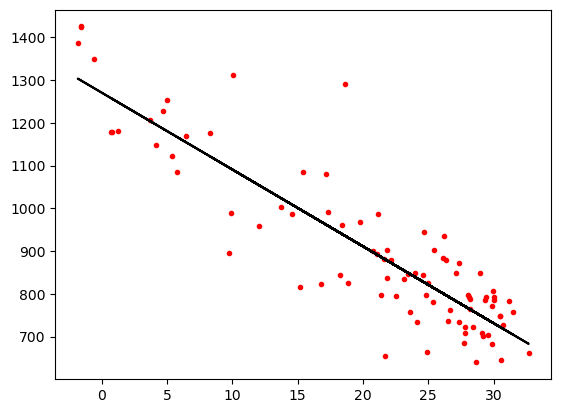

In [14]:
Reg_PEC_S=pt.calculate_R2(F8_MI['Amount  PEC (%)'].loc[Undegass], 
                          F8_MI['S_MI EPMA (ppm)'].loc[Undegass])
plt.plot(F8_MI['Amount  PEC (%)'].loc[Undegass], 
        F8_MI['S_MI EPMA (ppm)'].loc[Undegass], '.r')
plt.plot(Reg_PEC_S['x_pred'], Reg_PEC_S['y_pred'], '-k')
print(Reg_PEC_S['Grad'])
print(Reg_PEC_S['Int'])

## Regression for amount of sulfide removed per unit of PEC
- We are saying we have this much S initially. Then we have this amount of S in the melt, but the F is also reducing, together we can use these to account for the amount of S in the sulfide (As the mass and conc are changing). 

In [18]:
S_melt_calc=PEC_lin*Reg_PEC_S['Grad']+Reg_PEC_S['Int'] # This is the S in the melt
F_melt=1/(1+PEC_lin/100)

X_Sulf=ss.calculate_mass_frac_sulf(S_init=S_melt_calc[0], 
                                   S_model=S_melt_calc, F_melt=F_melt, S_sulf=32*10**4)

[[7.32826653e-05]]
[9.99946965e-05]


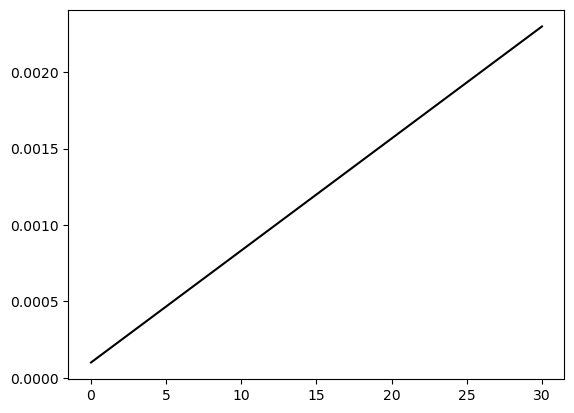

In [20]:
Reg_PEC_Sulf=pt.calculate_R2_np(PEC_lin, 
                          X_Sulf)
plt.plot(Reg_PEC_Sulf['x_pred'], Reg_PEC_Sulf['y_pred'], '-k')
print(Reg_PEC_Sulf['Grad'])
print(Reg_PEC_Sulf['Int'])

In [ ]:
### Lets show that this makes sense with a little mass balance
- Lets take a MI which has undergone 30% PEC. According to the regression above, it now has ~700 ppm S
- Lets say the sulfide has 32 wt% Sulfide. 
- Say it had 1270 ppm initially (the start of S_melt_calc)

In [32]:
## End of model - so 735 ppm S in the sulfide - very reasonable
Reg_PEC_Sulf['y_pred'][-1]*32*10**4

array([735.51188966])

## For Selenium

[-0.00786119]
[0.32331068]


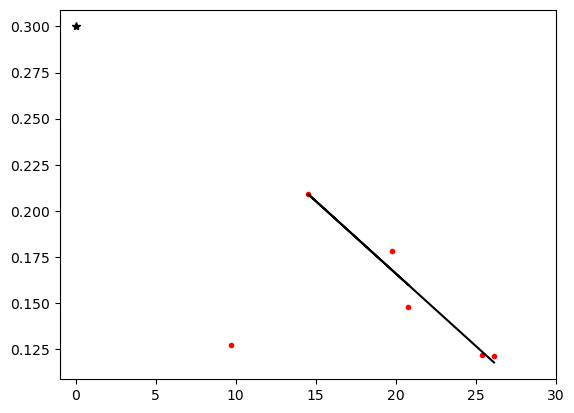

In [38]:
Reg_PEC_Se=pt.calculate_R2(F8_MI['Amount  PEC (%)'].loc[F8_MI['Amount  PEC (%)']>12.5], 
                           F8_MI['Se_96_ppm_m80'].loc[F8_MI['Amount  PEC (%)']>12.5])
plt.plot(F8_MI['Amount  PEC (%)'], F8_MI['Se_96_ppm_m80'], '.r')
plt.plot(Reg_PEC_Se['x_pred'], Reg_PEC_Se['y_pred'], '-k')
print(Reg_PEC_Se['Grad'])
print(Reg_PEC_Se['Int'])
plt.xlim([-1, 30])
plt.plot(0, 0.3, '*k') # This is the Se content in Mauna Ulu melt inclusions at ~0 PEc. 

## Looping through to get the amonut of sulfide in each step
- This gets the amount of sulfide removed in each step

In [35]:
FeO_lin=PEC_lin*Reg_PEC_FeO['Grad']+Reg_PEC_FeO['Int']
Ni_lin=PEC_lin*Reg_PEC_Ni['Grad']+Reg_PEC_Ni['Int']
T_K_lin=PEC_lin*Reg_PEC_T_K['Grad']+Reg_PEC_T_K['Int']
#X_Sulf=PEC_lin*Reg_PEC_Sulf['Grad']+Reg_PEC_Sulf['Int']
X_S=PEC_lin*Reg_PEC_S['Grad']+Reg_PEC_S['Int'] # This is the S in the melt

# This is the amoutn of sulfide removed per step of PEC
Delta_X_Sulf=np.empty(len(FeO_lin), dtype=float)
# This is the cumulative amount of sulfide by the time you get to X amount of PEC
Delta_X_Sulf_sum=np.empty(len(FeO_lin), dtype=float)




for i in range(0, len(PEC_lin)):
    if i==0:
        Delta_X_Sulf[i]=0
        Delta_X_Sulf_sum[i]=0
    else:

        Delta_X_Sulf[i]=X_Sulf[i]-X_Sulf[i-1]
        Delta_X_Sulf_sum[i]=X_Sulf[i]


## Setting up some other parameters
- Needed for the Kiseeva calculation. 

In [60]:
Fe3Fet_Liq=0.15
Cu_Liq=170 # See above, best match for PEC=
Se_Liq=0.32 # From Wieser et al. (2019) where we had a lot more measurments. np.max(F8_MI['Se_96_ppm_m80'])

bnds=((0, 30), (0, 30))

## First, we remove sulfide at each step with no re-equilibration
- This loop calculates the Ni and Cu content of the sulfide using Kiseeva et al. (2015), based on the minimizatoin routine of Smythe. 
- It also uses the FeO content, the temperature, and the Ni and Cu content of the liquid. 

In [61]:
# Removing sulfide with no re-equilibration
Cu_Liq_calc=np.empty(len(FeO_lin), dtype=float)
Cu_Liq_calc_wt=np.empty(len(FeO_lin), dtype=float)

S_Liq_calc=np.empty(len(FeO_lin), dtype=float)
Cu_Kd=np.empty(len(FeO_lin), dtype=float)

S_Liq=1200
for i in range(0, len(PEC_lin)):
    if i==0:
        # This step calculates the Ni and Cu content of the sulfide, using the FeO content, temperature, Ni and Cu of liquid,
        # Following the convergence method of Smythe et al. (2017)
        Calc_Sulf=scipy.optimize.minimize(ss.Loop_Smythe_sulf_calc_residual, x0=(0, 0), bounds=bnds,
                            args=(FeO_lin[i]*(1-Fe3Fet_Liq),
                                  T_K_lin[i], Ni_lin[i], Cu_Liq)).get('x')
        Ni_Sulf=Calc_Sulf[0]
        Cu_Sulf=Calc_Sulf[1]
        
        # Then, we feed this into a calculator for the Kd for Cu and Ni                 
        sulf_all=ss.calculate_sulf_kds(Ni_Sulf=Ni_Sulf, Cu_Sulf=Cu_Sulf,
                                FeOt_Liq=FeO_lin[i], Fe3Fet_Liq=Fe3Fet_Liq,
                                            T_K=T_K_lin[i])
       
        
        Cu_Kd[i]=sulf_all['DCu']
        # Now do a mass balance to get the Cu in the remaining liquid
        Cu_Liq_calc[i]=(Cu_Liq - Delta_X_Sulf[i]*Cu_Kd[i]*Cu_Liq*10**4)/(1-Delta_X_Sulf[i])
        Cu_Liq_calc_wt[i]=(Cu_Liq - Delta_X_Sulf[i]*Cu_Sulf)/(1-Delta_X_Sulf[i])
        # Same for sulfur
        S_Liq_calc[i]=(S_Liq - Delta_X_Sulf[i]*32*10**4)/(1-Delta_X_Sulf[i])
        
    else:
        Calc_Sulf=scipy.optimize.minimize(ss.Loop_Smythe_sulf_calc_residual, x0=(0, 0), bounds=bnds,
                    args=(FeO_lin[i]*(1-Fe3Fet_Liq),
                    T_K_lin[i], Ni_lin[i], Cu_Liq_calc[i-1])).get('x') 
        Ni_Sulf=Calc_Sulf[0]
        Cu_Sulf=Calc_Sulf[1]
        sulf_all=ss.calculate_sulf_kds(Ni_Sulf=Ni_Sulf, Cu_Sulf=Cu_Sulf,
                                FeOt_Liq=FeO_lin[i], Fe3Fet_Liq=Fe3Fet_Liq,
                                            T_K=T_K_lin[i])
        Cu_Kd[i]=sulf_all['DCu']
        
        Cu_Liq_calc[i]=(Cu_Liq_calc[i-1] - Delta_X_Sulf[i]*Cu_Kd[i]*Cu_Liq_calc[i-1])/(1-Delta_X_Sulf[i])
        # This is just me checking my math doing it not using the KD
        Cu_Liq_calc_wt[i]=(Cu_Liq_calc[i-1] - Delta_X_Sulf[i]*Cu_Sulf)/(1-Delta_X_Sulf[i])
                   
        S_Liq_calc[i]=(S_Liq_calc[i-1] - Delta_X_Sulf[i]*32*10**4)/(1-Delta_X_Sulf[i])
        
        if i>20:
            print('Cu_Sulf')
            print(Cu_Sulf)


Cu_Sulf
2.2710484988537236
Cu_Sulf
2.0705847361680196
Cu_Sulf
1.8893304247714076
Cu_Sulf
1.7250900238631628
Cu_Sulf
1.594697031123252
Cu_Sulf
1.6960004328413303
Cu_Sulf
1.8090034914869595
Cu_Sulf
1.9335703836625782
Cu_Sulf
2.069644247687588


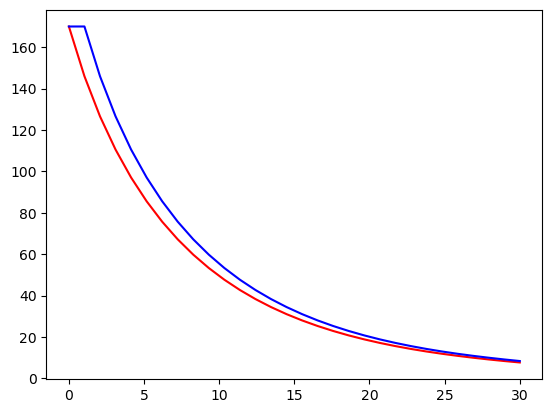

In [62]:
plt.plot(PEC_lin, Cu_Liq_calc, '-r')
plt.plot(PEC_lin, Cu_Liq_calc_wt, '-b')

1327.5245372564473

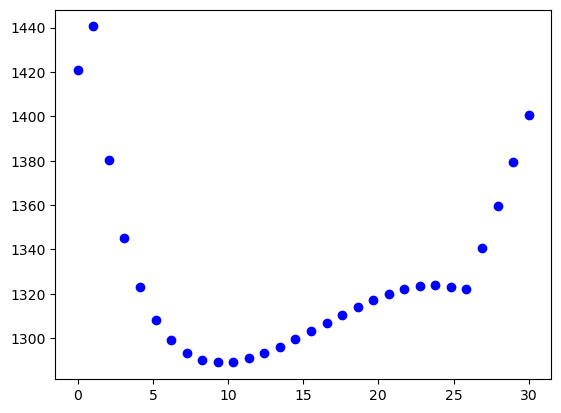

In [63]:
plt.plot(PEC_lin, Cu_Kd, 'ob')
np.mean(Cu_Kd)

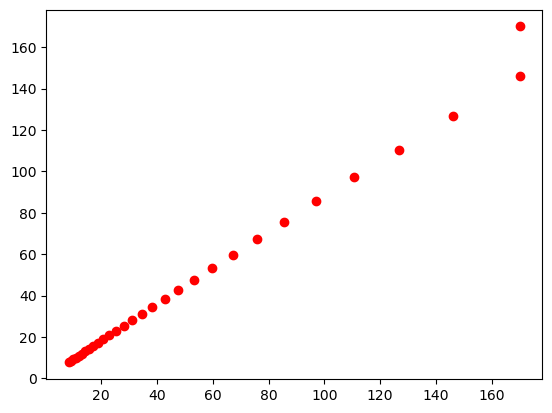

In [64]:
plt.plot(Cu_Liq_calc_wt, Cu_Liq_calc, 'or')

## Allowing re-equilibration

In [65]:
# Removing it with no re-equilibration
Cu_Liq_req_calc=np.empty(len(FeO_lin), dtype=float)
Cu_Liq_req_calc_wt=np.empty(len(FeO_lin), dtype=float)

Se_Liq_req_calc_Brenan=np.empty(len(FeO_lin), dtype=float)
Se_Liq_req_calc_Patten=np.empty(len(FeO_lin), dtype=float)
Cu_Sulf_req_calc=np.empty(len(FeO_lin), dtype=float)
S_Liq_req_calc=np.empty(len(FeO_lin), dtype=float)
Cu_Kd_req=np.empty(len(FeO_lin), dtype=float)
S_Liq=1200
for i in range(0, len(PEC_lin)):
    if i==0:

        Calc_Sulf=scipy.optimize.minimize(ss.Loop_Smythe_sulf_calc_residual, x0=(0, 0), bounds=bnds,
                            args=(FeO_lin[i]*(1-Fe3Fet_Liq),
                                  T_K_lin[i], Ni_lin[i], Cu_Liq)).get('x')
        Ni_Sulf=Calc_Sulf[0]
        Cu_Sulf=Calc_Sulf[1]
        Cu_Sulf_req_calc[i]=Cu_Sulf
        sulf_all=ss.calculate_sulf_kds(Ni_Sulf=Ni_Sulf, Cu_Sulf=Cu_Sulf,
                                FeOt_Liq=FeO_lin[i], Fe3Fet_Liq=Fe3Fet_Liq,
                                            T_K=T_K_lin[i])
        Cu_Liq_req_calc[i]=(Cu_Liq - Delta_X_Sulf[i]*Cu_Kd[i]*Cu_Liq)/(1-Delta_X_Sulf[i])
        Cu_Liq_req_calc_wt[i]=(Cu_Liq - Delta_X_Sulf[i]*Cu_Sulf*10**4)/(1-Delta_X_Sulf[i])

        S_Liq_req_calc[i]=(S_Liq - Delta_X_Sulf[i]*32*10**4)/(1-Delta_X_Sulf[i])
        Cu_Kd_req[i]=sulf_all['DCu']

        
    else:
        Calc_Sulf=scipy.optimize.minimize(ss.Loop_Smythe_sulf_calc_residual, x0=(0, 0), bounds=bnds,
                    args=(FeO_lin[i]*(1-Fe3Fet_Liq),
                    T_K_lin[i], Ni_lin[i-1], Cu_Liq_req_calc[i-1])).get('x') 
        Ni_Sulf=Calc_Sulf[0]
        Cu_Sulf=Calc_Sulf[1]
        Cu_Sulf_req_calc[i]=Cu_Sulf
        sulf_all=ss.calculate_sulf_kds(Ni_Sulf=Ni_Sulf, Cu_Sulf=Cu_Sulf,
                                FeOt_Liq=FeO_lin[i], Fe3Fet_Liq=Fe3Fet_Liq,
                                            T_K=T_K_lin[i])
        
        Cu_Kd_req[i]=sulf_all['DCu']
        # Different from above, as doing cumulative amount of sulfide
        Cu_Liq_req_calc[i]=(Cu_Liq - Delta_X_Sulf_sum[i]*Cu_Kd_req[i]*Cu_Liq)/(1-Delta_X_Sulf_sum[i])
        Cu_Liq_req_calc_wt[i]=(Cu_Liq - Delta_X_Sulf_sum[i]*Cu_Sulf_req_calc[i]*10**4)/(1-Delta_X_Sulf_sum[i])
        
        S_Liq_req_calc[i]=(S_Liq - Delta_X_Sulf_sum[i]*32*10**4)/(1-Delta_X_Sulf_sum[i])
        
        
        #if i>25:
            # print('Re-equilbrated Cu')
            # print(Cu_Liq_req_calc[i-1])
            # print('Cu_Sulf')
            # print(Cu_Sulf)  
            # print('amoutn of sulf')
            # print(Delta_X_Sulf_sum[i])
            # print('sulf comp')
            # print(sulf_all)

        

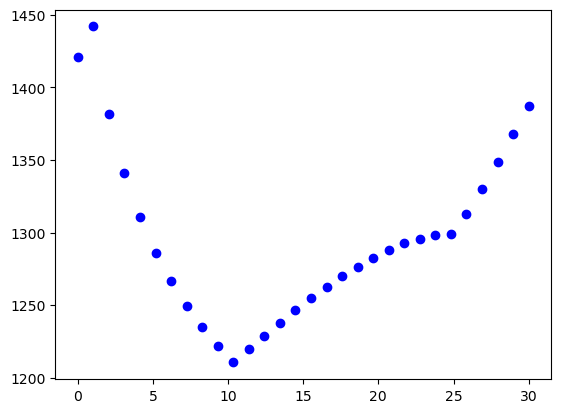

In [66]:
plt.plot(PEC_lin, Cu_Kd_req, 'ob')

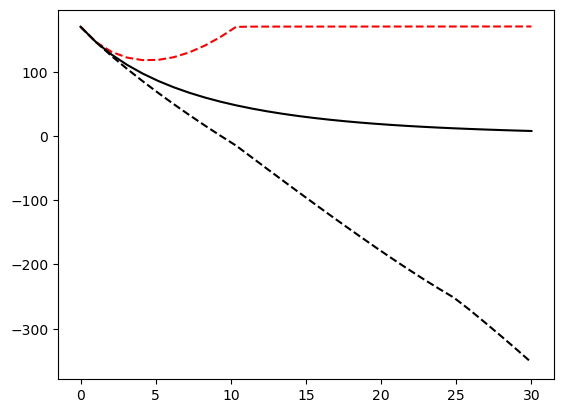

In [67]:
plt.plot(PEC_lin, Cu_Liq_req_calc, '--k')
plt.plot(PEC_lin, Cu_Liq_req_calc_wt, '--r')
plt.plot(PEC_lin, Cu_Liq_calc, '-k')

In [68]:
print(np.min(Cu_Kd_req))
print(np.max(Cu_Kd_req))

1210.5144295088733
1441.8868479208577


In [69]:
print(np.min(Cu_Kd))
print(np.max(Cu_Kd))

1289.0017307709602
1440.5326000300224


## Loop for Se which seems highly unstable

In [70]:
PEC_lin2=np.linspace(0, 30, 30)
FeO_lin2=PEC_lin2*Reg_PEC_FeO['Grad']+Reg_PEC_FeO['Int']
Ni_lin2=PEC_lin2*Reg_PEC_Ni['Grad']+Reg_PEC_Ni['Int']
T_K_lin2=PEC_lin2*Reg_PEC_T_K['Grad']+Reg_PEC_T_K['Int']
X_Sulf2=PEC_lin2*Reg_PEC_Sulf['Grad']+Reg_PEC_Sulf['Int']
X_S2=PEC_lin2*Reg_PEC_S['Grad']+Reg_PEC_S['Int']

# This is the amoutn of sulfide removed per step of PEC
Delta_X_Sulf2=np.empty(len(FeO_lin2), dtype=float)
# This is the cumulative amount of sulfide by the time you get to X amount of PEC
Delta_X_Sulf_sum2=np.empty(len(FeO_lin2), dtype=float)

for i in range(0, len(PEC_lin2)):
    if i==0:
        Delta_X_Sulf2[i]=0
        Delta_X_Sulf_sum2[i]=0
    else:
        Delta_X_Sulf2[i]=(X_S2[i-1]-X_S2[i])/(320000) # X_S[i]
        Delta_X_Sulf_sum2[i]=Delta_X_Sulf2[i]+Delta_X_Sulf_sum2[i-1]
        
        

Se_Liq_calc_Brenan=np.empty(len(FeO_lin2), dtype=float)
Se_Liq_calc_Patten=np.empty(len(FeO_lin2), dtype=float)
Se_Liq_calc_Brenan_req=np.empty(len(FeO_lin2), dtype=float)
Se_Liq_calc_Patten_req=np.empty(len(FeO_lin2), dtype=float)

for i in range(0, len(PEC_lin2)):
    if i==0:
        DSe_Brenan=(10**(3.47-3.07*10**(-2)*FeO_lin2[i] - 9.13*10**(-4)*FeO_lin2[i]**2))
        Se_Sulf_Brenan=DSe_Brenan*Se_Liq
        Se_Sulf_Patten=345*Se_Liq
        Se_Liq_calc_Brenan[i]=(Se_Liq - Delta_X_Sulf2[i]*Se_Sulf_Brenan)/(1-Delta_X_Sulf2[i])
        Se_Liq_calc_Patten[i]=(Se_Liq - Delta_X_Sulf2[i]*Se_Sulf_Patten)/(1-Delta_X_Sulf2[i])
        # If re-equilibrates
        Se_Liq_calc_Brenan_req[i]=(Se_Liq - Delta_X_Sulf2[i]*Se_Sulf_Brenan)/(1-Delta_X_Sulf2[i])
        Se_Liq_calc_Patten_req[i]=(Se_Liq - Delta_X_Sulf2[i]*Se_Sulf_Patten)/(1-Delta_X_Sulf2[i])

    else:
        DSe_Brenan=(10**(3.47-3.07*10**(-2)*FeO_lin2[i] - 9.13*10**(-4)*FeO_lin2[i]**2))
        Se_Sulf_Brenan=DSe_Brenan*Se_Liq_calc_Brenan[i-1]
        Se_Sulf_Patten=345*Se_Liq_calc_Brenan[i-1]
        Se_Liq_calc_Brenan[i]=(Se_Liq_calc_Brenan[i-1] - Delta_X_Sulf2[i]*Se_Sulf_Brenan)/(1-Delta_X_Sulf2[i])
        Se_Liq_calc_Patten[i]=(Se_Liq_calc_Patten[i-1]- Delta_X_Sulf2[i]*Se_Sulf_Patten)/(1-Delta_X_Sulf2[i])
        # IF requilibratse
        Se_Sulf_Brenan_req=DSe_Brenan*Se_Liq_calc_Brenan_req[i-1]
        Se_Sulf_Patten_req=345*Se_Liq_calc_Brenan_req[i-1]
        
        Se_Liq_calc_Brenan_req[i]=(Se_Liq - Delta_X_Sulf_sum2[i]*Se_Sulf_Brenan_req)/(1-Delta_X_Sulf_sum2[i])
        Se_Liq_calc_Patten_req[i]=(Se_Liq - Delta_X_Sulf_sum2[i]*Se_Sulf_Patten_req)/(1-Delta_X_Sulf_sum2[i])



In [71]:
DSe_Brenan=(10**(3.47-3.07*10**(-2)*FeO_lin2 - 9.13*10**(-4)*FeO_lin2**2))
print(np.min(DSe_Brenan))
print(np.max(DSe_Brenan))

1001.4809008481747
1753.4365565280057


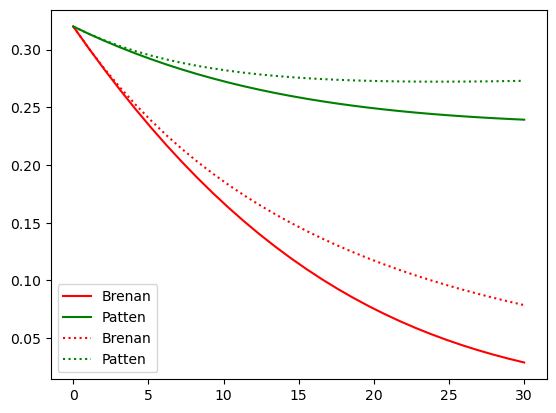

In [72]:
plt.plot(PEC_lin2, Se_Liq_calc_Brenan, '-r', label='Brenan')
plt.plot(PEC_lin2, Se_Liq_calc_Patten, '-g', label='Patten')
plt.plot(PEC_lin2, Se_Liq_calc_Brenan_req, ':r', label='Brenan')
plt.plot(PEC_lin2, Se_Liq_calc_Patten_req, ':g', label='Patten')
# plt.ylim([0, 0.3])
# plt.xlim([0, 30])
plt.legend()

## Cu loop using constnant Kd

In [73]:
for i in range(0, len(PEC_lin)):
    if i==0:
        Delta_X_Sulf2[i]=0
        Delta_X_Sulf_sum2[i]=0
    else:
        Delta_X_Sulf2[i]=(X_S2[i-1]-X_S2[i])/(320000) # X_S[i]
        Delta_X_Sulf_sum2[i]=Delta_X_Sulf2[i]+Delta_X_Sulf_sum2[i-1]
        
        

Cu_Liq_calc_1400=np.empty(len(FeO_lin), dtype=float)
Cu_Liq_calc_1600=np.empty(len(FeO_lin), dtype=float)
Cu_Liq_calc_1400_req=np.empty(len(FeO_lin), dtype=float)
Cu_Liq_calc_1600_req=np.empty(len(FeO_lin), dtype=float)

for i in range(0, len(PEC_lin2)):
    if i==0:
        DCu_1400=1400
        Cu_Sulf_1400=DCu_1400*Cu_Liq
        Cu_Sulf_1600=1600*Cu_Liq
        Cu_Liq_calc_1400[i]=(Cu_Liq - Delta_X_Sulf2[i]*Cu_Sulf_1400)/(1-Delta_X_Sulf2[i])
        Cu_Liq_calc_1600[i]=(Cu_Liq - Delta_X_Sulf2[i]*Cu_Sulf_1600)/(1-Delta_X_Sulf2[i])
        # If re-equilibrates
        Cu_Liq_calc_1400_req[i]=(Cu_Liq - Delta_X_Sulf2[i]*Cu_Sulf_1400)/(1-Delta_X_Sulf2[i])
        Cu_Liq_calc_1600_req[i]=(Cu_Liq - Delta_X_Sulf2[i]*Cu_Sulf_1600)/(1-Delta_X_Sulf2[i])

    else:
        DCu_1400=1400
        Cu_Sulf_1400=DCu_1400*Cu_Liq_calc_1400[i-1]
        Cu_Sulf_1600=1600*Cu_Liq_calc_1400[i-1]
        Cu_Liq_calc_1400[i]=(Cu_Liq_calc_1400[i-1] - Delta_X_Sulf2[i]*Cu_Sulf_1400)/(1-Delta_X_Sulf2[i])
        Cu_Liq_calc_1600[i]=(Cu_Liq_calc_1600[i-1]- Delta_X_Sulf2[i]*Cu_Sulf_1600)/(1-Delta_X_Sulf2[i])
        # IF requilibratse
        Cu_Sulf_1400_req=DCu_1400*Cu_Liq_calc_1400_req[i-1]
        Cu_Sulf_1600_req=1600*Cu_Liq_calc_1400_req[i-1]
        
        Cu_Liq_calc_1400_req[i]=(Cu_Liq - Delta_X_Sulf_sum2[i]*Cu_Sulf_1400_req)/(1-Delta_X_Sulf_sum2[i])
        Cu_Liq_calc_1600_req[i]=(Cu_Liq - Delta_X_Sulf_sum2[i]*Cu_Sulf_1600_req)/(1-Delta_X_Sulf_sum2[i])



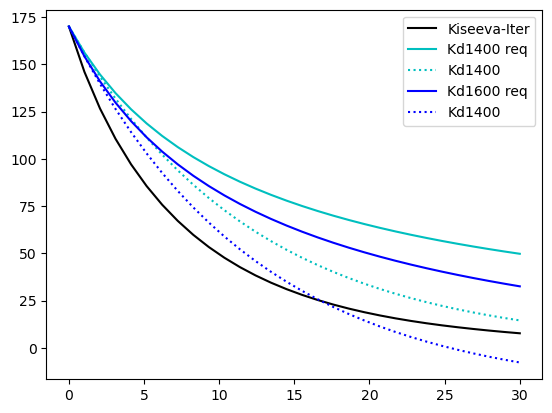

In [74]:
plt.plot(PEC_lin, Cu_Liq_calc, '-k', label='Kiseeva-Iter')
plt.plot(PEC_lin2, Cu_Liq_calc_1400_req, '-c', label='Kd1400 req')
plt.plot(PEC_lin2, Cu_Liq_calc_1400, ':c', label='Kd1400')
plt.plot(PEC_lin2, Cu_Liq_calc_1600_req, '-b', label='Kd1600 req')

plt.plot(PEC_lin2, Cu_Liq_calc_1600, ':b', label='Kd1400')
plt.legend()

In [75]:
DataFrame_Se=pd.DataFrame(data={'Amount PEC': PEC_lin2, 
                                'Se_Liq_Brenan_req':Se_Liq_calc_Brenan_req, 
                                'Se_Liq_Patten_req':Se_Liq_calc_Patten_req, 
                                'Se_Liq_Brenan':Se_Liq_calc_Brenan, 
                                'Se_Liq_Patten':Se_Liq_calc_Patten})
DataFrame_Se.to_excel('Se_PEC_model.xlsx', sheet_name="Sheet1")

In [76]:
DataFrame=pd.DataFrame(data={'Amount PEC': PEC_lin, 
                             'Cu_Liq_req':Cu_Liq_req_calc, 
                             'Cu_Liq_Frac':Cu_Liq_calc,
                             'S_Liq_req_calc': S_Liq_req_calc,
                             'Cu_Liq_1400_req': Cu_Liq_calc_1400_req,
                              'Cu_Liq_1400': Cu_Liq_calc_1400,
                             'Cu_Liq_1600_req': Cu_Liq_calc_1600_req,
                              'Cu_Liq_1600': Cu_Liq_calc_1600,
                            'S_Liq_Frac': S_Liq_calc})
DataFrame.to_excel('Cu_PEC_model.xlsx', sheet_name="Sheet1")

## Checking this is reasonable

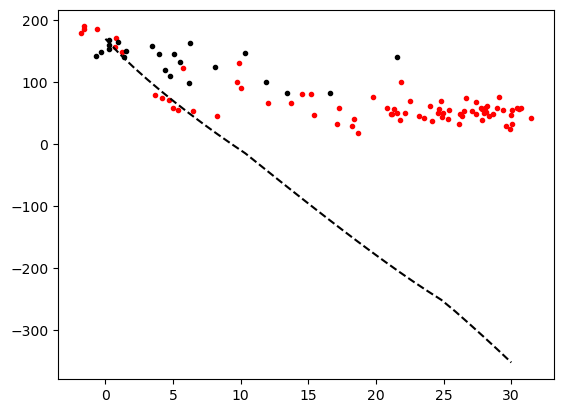

In [77]:


plt.plot(F8_MI['Amount  PEC (%)'].loc[Undegass], F8_MI['Cu_ppm_m65 LAICPMS'].loc[Undegass], '.r')
plt.plot(F8_MI['Amount  PEC (%)'].loc[~Undegass], F8_MI['Cu_ppm_m65 LAICPMS'].loc[~Undegass], '.k')

#plt.plot(PEC_lin, Cu_Liq_calc, '-k')
plt.plot(PEC_lin, Cu_Liq_req_calc, '--k')

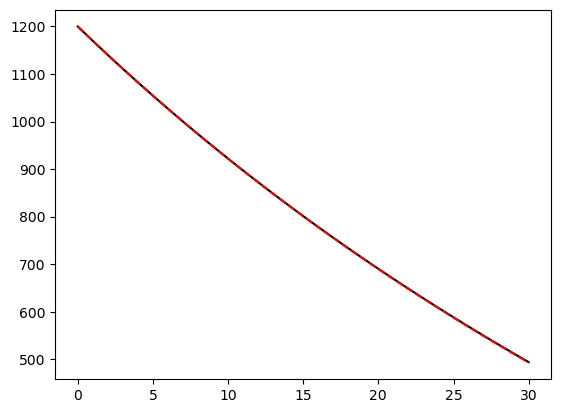

In [78]:
#plt.plot(F8_MI['Amount  PEC (%)'], F8_MI['Cu_ppm_m65 LAICPMS'], '.r')
plt.plot(PEC_lin, S_Liq_calc, '-k')
plt.plot(PEC_lin, S_Liq_req_calc, '--r')

NameError: name 'Has_Se' is not defined

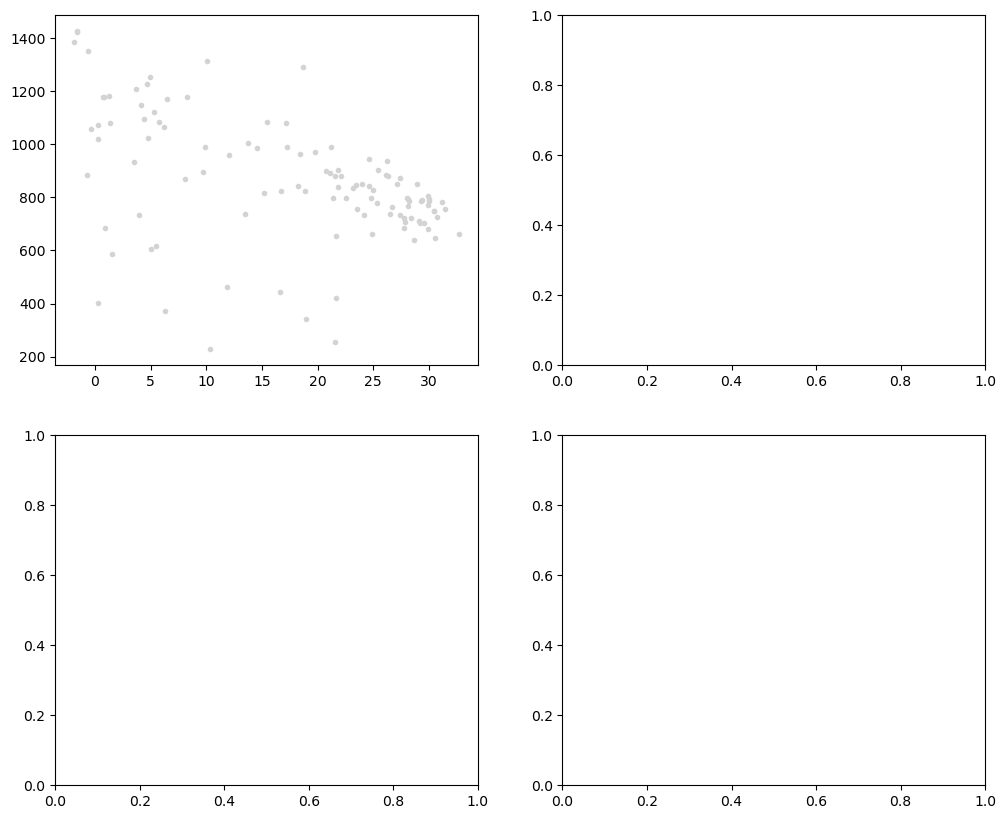

In [79]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (12,10)) # adjust dimensions of figure here

# plt.plot(F8_MI['Amount  PEC (%)'].loc[Has_Se], F8_MI['S_MI EPMA (ppm)'].loc[Has_Se], '.r')
# plt.scatter(F8_MI['Amount  PEC (%)'].loc[Has_Se], F8_MI['S_MI EPMA (ppm)'].loc[Has_Se],
#             marker='o', c=F8_MI['FeO_MI EPMA'].loc[Has_Se], ec='k', colormap='hot')
ax0.plot(F8_MI['Amount  PEC (%)'], F8_MI['S_MI EPMA (ppm)'], '.k', mec='lightgrey', mfc='lightgrey')
s=ax0.scatter(F8_MI['Amount  PEC (%)'].loc[Has_Se], F8_MI['S_MI EPMA (ppm)'].loc[Has_Se],
             marker='d', s=50, edgecolors='k', linewidths=0.5,
            c=F8_MI['FeO_MI EPMA'].loc[Has_Se], cmap='hot_r',
vmin = 6.5763, vmax = 9.1226, zorder=100)

s=ax1.scatter(F8_MI['Amount  PEC (%)'].loc[Has_Se], F8_MI['Se_96_ppm_m80'].loc[Has_Se],
             marker='d', s=50, edgecolors='k', linewidths=0.5,
            c=F8_MI['FeO_MI EPMA'].loc[Has_Se], cmap='hot_r',
vmin = 6.5763, vmax = 9.1226, zorder=100)


ax0.set_xlabel('Amount PEC (wt%)')
ax0.set_ylabel('S in MI (ppm)')

ax1.set_xlabel('Amount PEC (wt%)')
ax1.set_ylabel('Se in MI (ppm)')
fig.colorbar(s, ax=ax1, label='FeOt (wt%)')


In [ ]:
plt.plot(F8_MI['FeO_MI EPMA'].loc[Has_Se], F8_MI['S_MI EPMA (ppm)'].loc[Has_Se], '*r', ms=10)
plt.plot(F8_MI['FeO_MI EPMA'], F8_MI['S_MI EPMA (ppm)'], '.k')
plt.plot(F8_MI['FeO_MI EPMA'], grad*F8_MI['FeO_MI EPMA']+inter+210, '-r')

